# 0. Install and Import Dependencies

In [1]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.2.2
anyio                     4.5.2
appnope                   0.1.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
astunparse                1.6.3
async-lru                 2.0.4
attrs                     25.3.0
babel                     2.17.0
backcall                  0.2.0
beautifulsoup4            4.13.4
bleach                    6.1.0
blinker                   1.8.2
cachetools                5.5.2
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.4.1
click                     8.1.8
comm                      0.2.2
contourpy                 1.1.1
cycler                    0.12.1
debugpy                   1.8.14
decorator                 5.2.1
defusedxml                0.7.1
exceptiongroup            1.2.2
executing                 2.2.0
fastjsonschema   

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [5]:
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=3aef0f5c-7775-481d-ab7c-512cc590f786
To: /Users/nirmitkhurana/Desktop/LipNet/data.zip
100%|██████████| 423M/423M [00:08<00:00, 52.9MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2025-04-20 21:12:31.856202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-20 21:12:31.857063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
import os

def load_data(path: tf.Tensor):
    path = bytes.decode(path.numpy())

    # ✅ Get file name without extension in a platform-safe way
    file_name = os.path.splitext(os.path.basename(path))[0]

    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')


    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [15]:
test_path = '/content/data/s1/bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/content/data/s1/bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

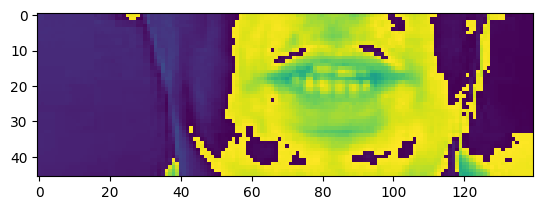

In [18]:
plt.imshow(frames[40])

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [22]:
from matplotlib import pyplot as plt

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [24]:
len(test)

50

In [25]:
frames, alignments = data.as_numpy_iterator().next()

2025-04-20 21:12:32.689275: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[1.3667005 ],
          [1.3667005 ],
          [1.4026663 ],
          ...,
          [0.32369223],
          [0.35965803],
          [0.35965803]],

         [[1.3667005 ],
          [1.3667005 ],
          [1.4026663 ],
          ...,
          [0.32369223],
          [0.35965803],
          [0.35965803]],

         [[1.4386321 ],
          [1.4386321 ],
          [1.4026663 ],
          ...,
          [0.32369223],
          [0.35965803],
          [0.35965803]],

         ...,

         [[1.0430083 ],
          [1.0430083 ],
          [1.0070425 ],
          ...,
          [0.0359658 ],
          [0.        ],
          [9.17128   ]],

         [[1.0430083 ],
          [1.0430083 ],
          [1.0070425 ],
          ...,
          [0.07193161],
          [9.17128   ],
          [9.17128   ]],

         [[1.0430083 ],
          [1.0430083 ],
          [1.0070425 ],
          ...,
          [0.0359658 ],
          [9.17128   ],
          [9.135314  ]]],


        [[[1.4745

In [29]:
frames = [((frame.squeeze() * 255).astype(np.uint8)) for frame in val[0][0]]

# Convert frames to a data type and value range compatible with imageio
frames_for_gif = [frame.astype(np.uint8) for frame in frames]

# Save the GIF
imageio.mimsave('./animation.gif', frames_for_gif, fps=10)

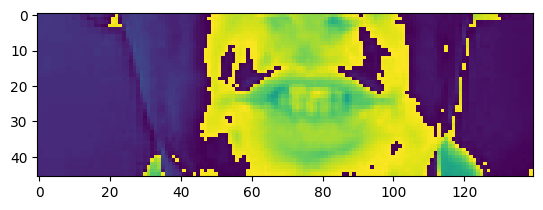

In [30]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white in j two now'>

# 3. Design the Deep Neural Network

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [36]:
5*17*75

6375

In [37]:
yhat = model.predict(val[0])

2025-04-20 21:12:36.682955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:12:38.766597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:12:38.779248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:12:39.454310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:12:39.464790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


In [38]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'3'>

In [39]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'3'>

In [40]:
model.input_shape

(None, 75, 46, 140, 1)

In [41]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [42]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [43]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [44]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [46]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [47]:
schedule_callback = LearningRateScheduler(scheduler)

In [48]:
example_callback = ProduceExample(test)

In [49]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [50]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=7f202fae-ff2d-4073-b91e-f39f8ba8f2f1
To: /Users/nirmitkhurana/Desktop/LipNet/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:03<00:00, 30.9MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [51]:
model.load_weights('models/checkpoint')

In [52]:
test_data = test.as_numpy_iterator()

In [53]:
sample = test_data.next()

[mpeg1video @ 0x3a445a7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x3a445a7c0] Warning MVs not available


In [54]:
yhat = model.predict(sample[0])

2025-04-20 21:16:18.343219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:16:20.580486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:16:20.591405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:16:21.173111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-20 21:16:21.185101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


In [55]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red by d zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red in f four now'>]

In [56]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [57]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red by d zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red in f four now'>]

In [58]:
model.save("clean_lipnet_model.h5")

# Test on a Video

In [ ]:
# List of test video paths 
test_video_paths = [
    "/data/s1/bbal8p.mpg",
    "/data/s1/bbaf2n.mpg",
    "/data/s1/bbas3a.mpg",
    "/data/s1/bbas1s.mpg"

]

In [ ]:
from jiwer import wer
import matplotlib.pyplot as plt
import numpy as np

# 📊Store results
true_texts = []
pred_texts = []
accuracies = []
wers = []

for video_path in test_video_paths:
    sample = load_data(tf.convert_to_tensor(video_path))

    # Ground truth text
    real_text_tensor = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
    real_text = real_text_tensor[0].numpy().decode("utf-8").strip()

    # Model prediction
    yhat = model.predict(tf.expand_dims(sample[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    pred_text_tensor = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    pred_text = pred_text_tensor[0].numpy().decode("utf-8").strip()

    # append results
    true_texts.append(real_text)
    pred_texts.append(pred_text)

    accuracies.append(1 if real_text == pred_text else 0)
    wers.append(wer(real_text, pred_text))

NameError: name 'test_video_paths' is not defined

=== Evaluation Summary ===
✅ Mean Accuracy: 0.75
📉 Mean WER     : 0.04


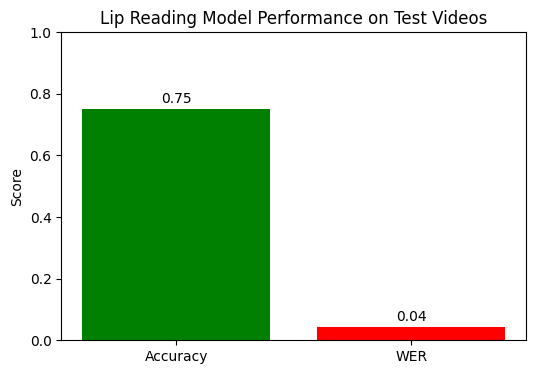

In [ ]:
# Mean performance
mean_accuracy = np.mean(accuracies)
mean_wer = np.mean(wers)

print("=== Evaluation Summary ===")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Mean WER     : {mean_wer:.2f}")

# Plot bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(["Accuracy", "WER"], [mean_accuracy, mean_wer], color=["green", "red"])
plt.title("Lip Reading Model Performance on Test Videos")
plt.ylim(0, 1)
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha="center")
plt.show()

In [64]:
# sample = load_data(tf.convert_to_tensor('/data/s1/bbal8p.mpg'))

In [65]:
# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [67]:
# yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [68]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [69]:
# print('~'*100, 'PREDICTIONS')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]